# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [2]:
# %pip install umap-learn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [4]:
import os

# listar archivos en el directorio actual
print("Archivos en la carpeta actual:", os.listdir())

# buscar yaml.py en todo el proyecto
for root, dirs, files in os.walk("."):
    for f in files:
        if f.startswith("yaml") and f.endswith(".py"):
            print("⚠️ Encontrado:", os.path.join(root, f))


Archivos en la carpeta actual: ['.git', '.gitignore', 'consulta_SQL.py', 'data', 'intro.ipynb', 'main.py', 'mi_proyecto.duckdb', 'mi_proyecto.duckdb.tmp', 'modelo.ipynb', 'README.md', 'requirements.txt', 'schema.json', 'venv', 'z502_Segmentacion.ipynb', '__pycache__']
⚠️ Encontrado: .\venv\Lib\site-packages\jupyter_events\yaml.py
⚠️ Encontrado: .\venv\Lib\site-packages\jupyter_lsp\specs\yaml_language_server.py


In [5]:

from umap import UMAP
print("UMAP OK")




UMAP OK


In [6]:
#base_path = '/content/drive/MyDrive/DMEyF/2025/'
#dataset_path = base_path + 'datos/'
#modelos_path = base_path + 'modelos/'
#db_path = base_path + 'db/'
#dataset_file = 'competencia_01.csv'

In [7]:
df_train = pd.read_csv("data/df_abril.csv")

In [8]:
df_train = df_train.drop(columns=[
    'foto_mes_max', 
    'slope_Visa_fechaalta', 
    'slope_Master_fechaalta', 
    'slope_Visa_Fvencimiento', 
    'slope_Master_Fvencimiento', 
    'slope_Visa_fultimo_cierre', 
    'slope_Master_fultimo_cierre'
])


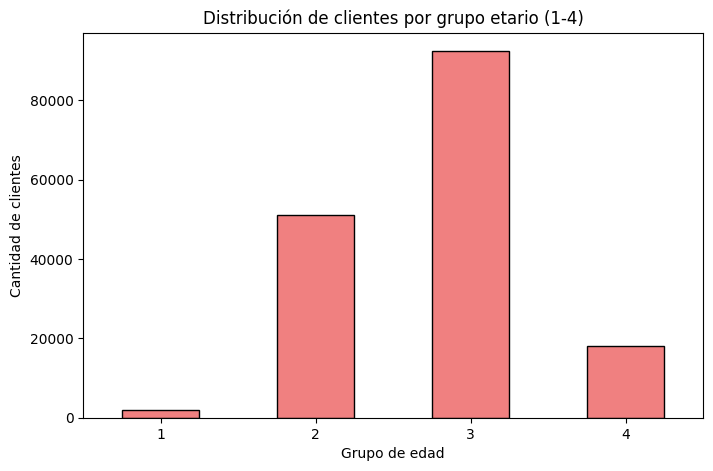

   cliente_edad grupo_edad
0            54          3
1            43          3
2            43          3
3            45          3
4            55          3
5            47          3
6            46          3
7            48          3
8            45          3
9            54          3


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

# Definir los cortes de edad y los números de grupo
bins = [18, 25, 40, 65, df_train['cliente_edad'].max()]
labels = [1, 2, 3, 4]  # 1=Jóvenes, 2=Adultos jóvenes, 3=Adultos, 4=Ancianos

# Crear nueva columna con la categoría numérica
df_train['grupo_edad'] = pd.cut(df_train['cliente_edad'], bins=bins, labels=labels, right=False)

# Contar cuántos clientes hay en cada grupo
edad_counts = df_train['grupo_edad'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(8,5))
edad_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Distribución de clientes por grupo etario (1-4)")
plt.xlabel("Grupo de edad")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=0)
plt.show()

# Mostrar primeros registros para verificar
print(df_train[['cliente_edad', 'grupo_edad']].head(10))



Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [10]:
#jovenes

In [11]:
#df_train_ad_jov =df_train[df_train['grupo_edad']==2]
#df_train_jov = df_train_ad_jov.drop(['grupo_edad'], axis=1)
#df_train_ad_jov.shape

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [12]:
Xtrain = df_train
# ytrain: binarizamos clase_ternaria
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

# Eliminamos columnas innecesarias de Xtrain
Xtrain = Xtrain.drop(["clase_ternaria"], axis=1)

# Liberar memoria (opcional)
del df_train

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [13]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [14]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, random_state=17 )
model.fit(Xtrain_rf_imp, ytrain_rf)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,400
,min_weight_fraction_leaf,0.0
,max_features,20
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [15]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [16]:
md

array([[0.  , 0.59, 0.82, ..., 0.94, 0.66, 0.71],
       [0.59, 0.  , 0.87, ..., 0.96, 0.56, 0.69],
       [0.82, 0.87, 0.  , ..., 0.87, 0.64, 0.59],
       ...,
       [0.94, 0.96, 0.87, ..., 0.  , 0.97, 0.94],
       [0.66, 0.56, 0.64, ..., 0.97, 0.  , 0.49],
       [0.71, 0.69, 0.59, ..., 0.94, 0.49, 0.  ]], shape=(4085, 4085))

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

c:\Users\Flor\Documents\UBA\DMEyF\venv\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\Flor\Documents\UBA\DMEyF\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


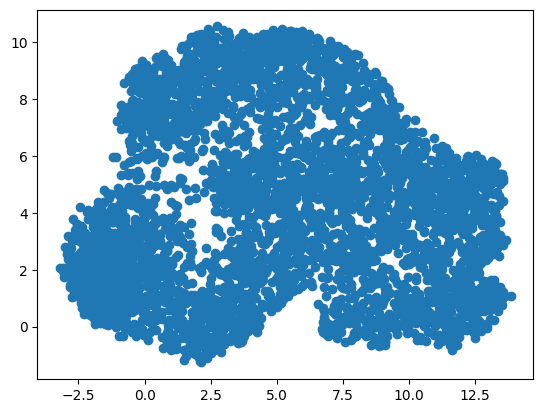

In [17]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=20,
  min_dist=0.77,
  learning_rate=0.05,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

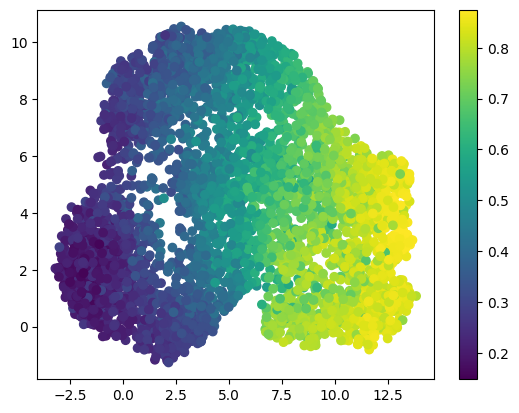

In [18]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

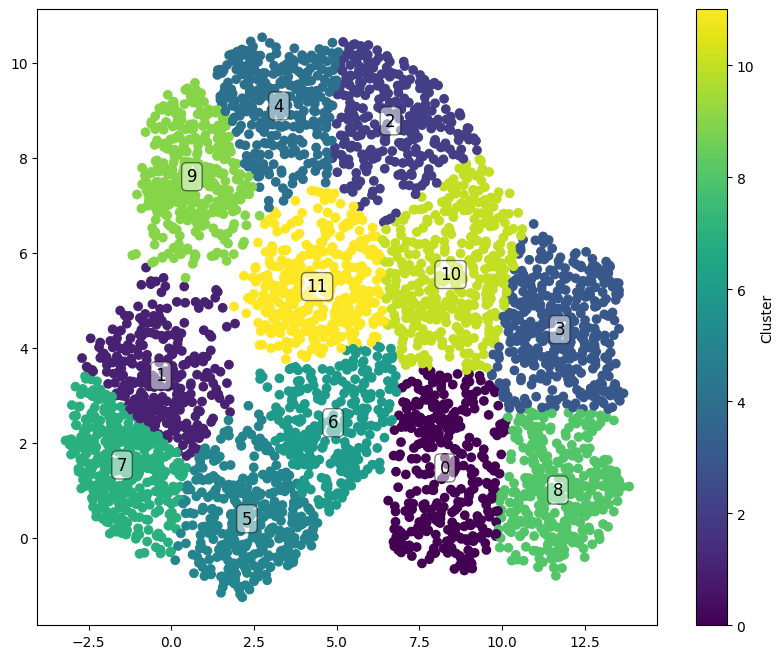

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=12,random_state=17, n_init=10)
clusters = kmeans.fit_predict(embedding_rf)


plt.figure(figsize=(10, 8))
plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster')

for cluster_label in sorted(np.unique(clusters)):
    cluster_points = embedding_rf[clusters == cluster_label]
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, ha='center', va='center', color='black',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))

plt.show()

Veamos cuales de los clientes de cada cluster son **bajas** y cuales **continuan** y la proba promedio del cluster

In [20]:
cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': ytrain_rf})

class_distribution_by_cluster = cluster_class_df.groupby('cluster')['original_class'].value_counts().unstack(fill_value=0)
cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster

print("Number of cases per class and average churn probability per cluster:")
print(class_distribution_by_cluster)

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0                38  298           0.750686
1               265   31           0.264745
2               104  192           0.557917
3                26  374           0.819605
4               221  101           0.391527
5               332   20           0.299257
6               127  141           0.496250
7               377   13           0.207081
8                25  309           0.815711
9               272   90           0.304101
10               62  317           0.684777
11              151  199           0.492746


Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

Y exploramos las diferencias entre los clusters usando las **n** variables más importantes, usando en este caso la mediana


In [21]:
# sacar las features más importantes
importances = model.feature_importances_
feature_names = Xtrain_rf.columns
feature_importance_series = pd.Series(importances, index=feature_names)

feature_selected = feature_importance_series.sort_values(ascending=False)

n_top = 20 #cntidad de variables a evaluar.
top_overall_features = feature_selected.head(n_top).index.tolist()

cluster_series_aligned = pd.Series(clusters, index=Xtrain_rf.index)

cluster_median_values = {}

for cluster in sorted(np.unique(clusters)):
    cluster_indices = cluster_series_aligned[cluster_series_aligned == cluster].index
    cluster_data = Xtrain_rf.loc[cluster_indices, top_overall_features]

    # Usar el estadístico de su preferencia
    values = cluster_data.median()
    cluster_median_values[f'Cluster {cluster}'] = values

top_overall_features_df = pd.DataFrame(cluster_median_values).round(2)
display(top_overall_features_df)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11
ctrx_quarter_max,10.00,142.50,43.00,9.00,100.00,117.00,64.00,169.00,8.00,167.50,28.00,89.00
mcaja_ahorro,0.00,19840.06,164.89,0.00,12046.04,33848.02,8234.20,49655.99,0.00,34846.48,1230.78,13133.29
ctrx_quarter,4.00,119.50,37.00,6.00,84.50,103.00,48.00,155.50,3.00,147.00,22.00,70.50
mpasivos_margen_max,34.67,1531.47,480.23,10.42,1350.96,1221.44,476.92,2140.36,26.10,2066.96,151.74,776.09
mautoservicio,0.00,6961.64,0.00,0.00,0.00,21470.40,1286.95,27829.46,0.00,15987.86,0.00,3782.47
mcaja_ahorro_max,36.59,55127.25,2263.17,78.74,29036.66,68039.28,26337.14,95367.33,0.00,74565.76,4188.29,40864.80
mautoservicio_min,0.00,629.90,0.00,0.00,0.00,9608.56,0.00,12055.28,0.00,4102.87,0.00,0.00
ctrx_quarter_min,2.00,105.50,29.00,3.00,70.00,88.00,41.00,138.00,2.00,123.50,18.00,59.00
mtarjeta_visa_consumo_min,0.00,22237.68,13332.72,0.00,19220.00,3004.41,0.00,19054.57,0.00,22011.92,1052.41,885.24
slope_mpayroll,0.00,8275.96,0.00,0.00,0.00,8723.21,0.00,11092.92,0.00,0.00,0.00,0.00


In [22]:
cluster_data

,ctrx_quarter_max,mcaja_ahorro,ctrx_quarter,mpasivos_margen_max,mautoservicio,mcaja_ahorro_max,mautoservicio_min,ctrx_quarter_min,mtarjeta_visa_consumo_min,slope_mpayroll,mtarjeta_visa_consumo,mcaja_ahorro_min,mactivos_margen,mpasivos_margen_min,mautoservicio_max,Visa_msaldopesos,cpayroll_trx_min,mcuentas_saldo,cpayroll_trx_max,mpayroll_max
174,61,22010.30,59,597.08,0.00,48240.07,0.00,52,1718.89,0.0,1718.89,15717.93,-12.90,225.99,10114.60,1718.89,0,22165.10,0,0.0
858,93,15665.86,93,882.85,23421.25,73682.88,4647.15,77,0.00,0.0,0.00,11869.97,-2783.03,178.55,23421.25,NaN,0,-2038.15,0,0.0
1342,115,62123.51,110,2233.20,102487.36,173800.87,42565.73,70,460.36,0.0,2239.40,34901.27,404.03,459.85,102487.36,2266.28,0,34402.47,0,0.0
1385,63,3513.29,53,221.84,0.00,8993.02,0.00,53,0.00,0.0,0.00,2288.59,-225.03,76.96,1173.00,0.00,0,-4170.57,0,0.0
1393,90,0.00,79,683.89,0.00,152.31,0.00,79,0.00,0.0,0.00,0.00,3281.04,464.84,694.41,NaN,0,29938.67,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162026,88,0.00,77,1673.33,1612.87,1193.63,1612.87,74,0.00,0.0,9618.60,0.00,-405.18,10.17,74250.90,9734.02,0,-9667.06,0,0.0
162052,113,142841.24,108,4604.92,65863.04,343906.56,65863.04,82,0.00,0.0,0.00,142841.24,90.29,1828.35,214865.28,0.00,0,64977.11,0,0.0
162162,319,16172.42,209,1554.90,12935.84,37912.63,0.00,209,1071.32,0.0,2537.51,4483.21,-2093.33,272.46,21892.25,2647.02,0,156724.41,0,0.0
162592,35,94273.64,35,3591.50,1372.41,103664.37,0.00,16,2103.18,0.0,10981.14,14158.12,-1432.71,1746.31,1372.41,9157.21,0,154834.93,0,0.0


Otra de forma de explorar es graficar uno contra todos

In [23]:
def compare_cluster_stats(data, clusters, variable_name, target_cluster):
    cluster_series_aligned = pd.Series(clusters, index=data.index)
    variable_data = data[variable_name]

    target_cluster_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices]

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices]

    # Describe
    target_cluster_desc = target_cluster_data.dropna().describe()
    rest_desc = rest_data.dropna().describe()

    # Convertir counts y min/max a enteros
    int_rows = ['count', 'min', '25%', '50%', '75%', 'max']
    for row in int_rows:
        if row in target_cluster_desc.index:
            target_cluster_desc[row] = int(round(target_cluster_desc[row]))
        if row in rest_desc.index:
            rest_desc[row] = int(round(rest_desc[row]))

    summary_df = pd.DataFrame({
        f'Cluster {target_cluster}': target_cluster_desc,
        f'Rest of Clusters': rest_desc
    })

    # unique y missing como enteros
    summary_df.loc['unique'] = [target_cluster_data.nunique(), rest_data.nunique()]
    summary_df.loc['missing'] = [target_cluster_data.isnull().sum(), rest_data.isnull().sum()]

    # Asegurarse de que unique y missing también sean enteros
    summary_df.loc['unique'] = summary_df.loc['unique'].astype(int)
    summary_df.loc['missing'] = summary_df.loc['missing'].astype(int)

    return summary_df

# Ejemplo de uso
print(f"'mcaja_ahorro' - Cluster 10 s. Rest")
compare_cluster_stats(Xtrain_rf, clusters, 'mcaja_ahorro', 10)


'mcaja_ahorro' - Cluster 10 s. Rest


,Cluster 10,Rest of Clusters
count,379.000000,3.706000e+03
mean,6857.831214,4.877380e+04
std,25357.460140,1.610849e+05
min,0.000000,0.000000e+00
25%,16.000000,0.000000e+00
50%,1231.000000,6.539000e+03
75%,4632.000000,3.574400e+04
max,303408.000000,3.378951e+06
unique,301.000000,2.765000e+03
missing,0.000000,0.000000e+00


In [24]:
# Crear variable binned de antigüedad
def bin_antiguedad(df):
    df = df.copy()
    bins = [-1, 12, 24, 60, 120, np.inf]  # límites de los bins
    labels = [0, 1, 2, 3, 4]            # etiquetas
    df['antiguedad_binned'] = pd.cut(df['cliente_antiguedad'], bins=bins, labels=labels).astype(int)
    return df

# Uso
Xtrain_rf_features = bin_antiguedad(Xtrain_rf_features)

# Ejemplo de uso con tu función de comparación
print(f"'antiguedad_binned' - Cluster 10 s. Rest")
compare_cluster_stats(Xtrain_rf_features, clusters, 'antiguedad_binned', 10)


NameError: name 'Xtrain_rf_features' is not defined

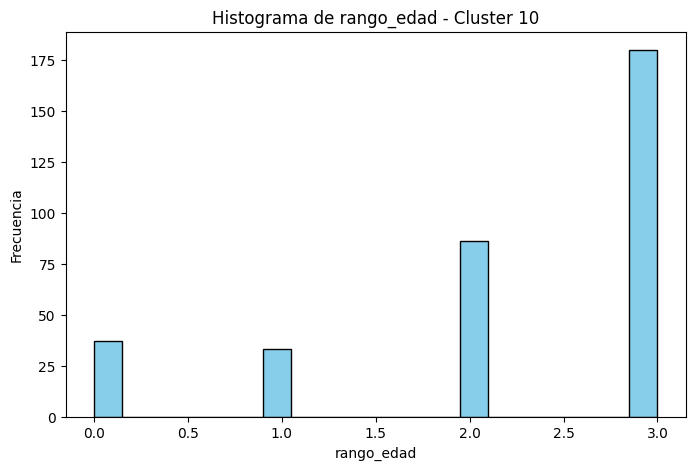

In [ ]:
# Filtrar filas del cluster 10
cluster_10_data = Xtrain_rf_features[cluster_class_df['cluster'] == 0]['antiguedad_binned']

# Plotear histograma
plt.figure(figsize=(8,5))
plt.hist(cluster_10_data.dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("Histograma de rango_edad - Cluster 10")
plt.xlabel("rango_edad")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:

# Filtrar Cluster 10
cluster10_data = Xtrain_rf_features.loc[Xtrain_rf_features['cluster'] == 10, 'antiguedad_binned']

# Calcular porcentaje de clientes con antiguedad_binned >= 3
porcentaje_3_o_mas = (cluster10_data <= 1).mean() * 100
print(f"Porcentaje de clientes en Cluster 10 con antiguedad >= 3: {porcentaje_3_o_mas:.2f}%")


Porcentaje de clientes en Cluster 10 con antiguedad >= 3: 6.86%


In [ ]:


def summarize_clusters(data, clusters, variable, high_risk_clusters=[0,3,8,10]):
    data = data.copy()
    data['cluster'] = clusters
    
    summary_dict = {}
    
    # Calcular stats para cada cluster de alto riesgo
    for c in high_risk_clusters:
        cluster_data = data.loc[data['cluster']==c, variable]
        summary_dict[f'Cluster {c}'] = cluster_data.describe()
        summary_dict[f'Cluster {c}']['unique'] = cluster_data.nunique()
        summary_dict[f'Cluster {c}']['missing'] = cluster_data.isnull().sum()
    
    # Calcular stats para el resto
    rest_data = data.loc[~data['cluster'].isin(high_risk_clusters), variable]
    summary_dict['Rest of Clusters'] = rest_data.describe()
    summary_dict['Rest of Clusters']['unique'] = rest_data.nunique()
    summary_dict['Rest of Clusters']['missing'] = rest_data.isnull().sum()
    
    # Combinar en un DataFrame final
    final_df = pd.DataFrame(summary_dict)
    return final_df

# Ejemplo de uso
summary = summarize_clusters(Xtrain_rf, clusters, 'cliente_antiguedad').round(2)
display(summary)


,Cluster 0,Cluster 3,Cluster 8,Cluster 10,Rest of Clusters
count,336.00,400.00,334.00,379.00,2636.00
mean,91.75,86.94,109.42,119.53,134.47
std,81.58,73.44,79.53,83.50,85.90
min,1.00,8.00,11.00,2.00,1.00
25%,33.00,34.75,45.00,52.00,62.00
50%,66.00,60.00,87.00,107.00,125.00
75%,130.50,126.25,162.00,163.50,191.00
max,376.00,376.00,376.00,376.00,376.00
unique,162.00,168.00,162.00,190.00,314.00
missing,0.00,0.00,0.00,0.00,0.00


In [ ]:
# 🔹 1. Calcular ratios de endeudamiento
Xtrain_rf_features = Xtrain_rf_features.copy()

# Uso de tarjeta (Visa + Master por ejemplo)
Xtrain_rf_features['uso_credito_visa'] = Xtrain_rf_features['Visa_msaldototal'] / (Xtrain_rf_features['Visa_mlimitecompra'] + 1e-6)
Xtrain_rf_features['uso_credito_master'] = Xtrain_rf_features['Master_msaldototal'] / (Xtrain_rf_features['Master_mlimitecompra'] + 1e-6)

# Ratio deuda / ingresos
Xtrain_rf_features['ratio_deuda_ingresos'] = (
    Xtrain_rf_features['deuda_total_calc'] / (Xtrain_rf_features['ingreso_total_calc'] + 1e-6)
)

# 🔹 2. Resumen por cluster
def summarize_ratio_cluster(data, clusters, variable, high_risk_clusters=[0,3,8,10]):
    data = data.copy()
    data['cluster'] = clusters
    
    summary_dict = {}
    
    # Stats por cluster de alto riesgo
    for c in high_risk_clusters:
        cluster_data = data.loc[data['cluster']==c, variable]
        summary_dict[f'Cluster {c}'] = {
            'Mediana': cluster_data.median(),
            'Media': cluster_data.mean(),
            'Porc_0': (cluster_data==0).mean()*100  # opcional: % sin deuda o sin uso de tarjeta
        }
    
    # Stats para el resto
    rest_data = data.loc[~data['cluster'].isin(high_risk_clusters), variable]
    summary_dict['Rest of Clusters'] = {
        'Mediana': rest_data.median(),
        'Media': rest_data.mean(),
        'Porc_0': (rest_data==0).mean()*100
    }
    
    return pd.DataFrame(summary_dict).T.round(2)

# Ejemplo de uso
summary_uso_credito_visa = summarize_ratio_cluster(Xtrain_rf_features, clusters, 'uso_credito_visa')
summary_ratio_deuda_ingresos = summarize_ratio_cluster(Xtrain_rf_features, clusters, 'ratio_deuda_ingresos')

display(summary_uso_credito_visa)
display(summary_ratio_deuda_ingresos)


,Mediana,Media,Porc_0
Cluster 0,0.00,0.03,36.61
Cluster 3,0.00,0.05,64.00
Cluster 8,0.06,0.49,3.59
Cluster 10,0.01,0.03,19.00
Rest of Clusters,0.08,0.13,8.73


,Mediana,Media,Porc_0
Cluster 0,0.00,5604194910.98,30.36
Cluster 3,0.00,2485172999.78,46.00
Cluster 8,4875270000.00,169081110584.89,2.10
Cluster 10,1.40,3039740938.26,12.93
Rest of Clusters,0.41,9302870605.74,6.79


In [ ]:
Xtrain_rf_features = Xtrain_rf_features.copy()

# 🔹 1. Gasto total
Xtrain_rf_features['gasto_total'] = (
    Xtrain_rf_features['mtarjeta_visa_consumo'] +
    Xtrain_rf_features['mtarjeta_master_consumo'] +
    Xtrain_rf_features['mpagodeservicios'] +
    Xtrain_rf_features['mpagomiscuentas'] +
    Xtrain_rf_features['mtransferencias_emitidas'] +
    Xtrain_rf_features['mautoservicio'] +  # compras POS
    Xtrain_rf_features['mextraccion_autoservicio']  # compras online / efectivo
)

# 🔹 2. Ingreso total
Xtrain_rf_features['ingreso_total'] = (
    Xtrain_rf_features['mpayroll'] +
    Xtrain_rf_features['mpayroll2'] +
    Xtrain_rf_features['mtransferencias_recibidas'] +
    Xtrain_rf_features['mcheques_depositados']
)

# 🔹 3. Ahorro total
Xtrain_rf_features['ahorro_total'] = (
    Xtrain_rf_features['mcaja_ahorro'] +
    Xtrain_rf_features['mplazo_fijo_pesos'] +
    Xtrain_rf_features['mplazo_fijo_dolares'] +
    Xtrain_rf_features['minversion1_pesos'] +
    Xtrain_rf_features['minversion2']
)

# 🔹 4. Deuda total
Xtrain_rf_features['deuda_total'] = (
    Xtrain_rf_features['mprestamos_personales'] +
    Xtrain_rf_features['mprestamos_hipotecarios'] +
    Xtrain_rf_features['mprestamos_prendarios'] +
    Xtrain_rf_features['Visa_msaldototal'] +
    Xtrain_rf_features['Master_msaldototal']
)


In [ ]:
def summarize_agg_cluster(data, clusters, variable, high_risk_clusters=[0,3,8,10]):
    data = data.copy()
    data['cluster'] = clusters
    
    summary_dict = {}
    
    for c in high_risk_clusters:
        cluster_data = data.loc[data['cluster']==c, variable]
        summary_dict[f'Cluster {c}'] = {
            'Mediana': cluster_data.median(),
            'Media': cluster_data.mean(),
            'Porc_0': (cluster_data==0).mean()*100
        }
    
    # Resto de los clusters
    rest_data = data.loc[~data['cluster'].isin(high_risk_clusters), variable]
    summary_dict['Rest of Clusters'] = {
        'Mediana': rest_data.median(),
        'Media': rest_data.mean(),
        'Porc_0': (rest_data==0).mean()*100
    }
    
    return pd.DataFrame(summary_dict).T.round(2)


In [ ]:
summary_gasto_total = summarize_agg_cluster(Xtrain_rf_features, clusters, 'gasto_total')
summary_ingreso_total = summarize_agg_cluster(Xtrain_rf_features, clusters, 'ingreso_total')
summary_ahorro_total = summarize_agg_cluster(Xtrain_rf_features, clusters, 'ahorro_total')
summary_deuda_total = summarize_agg_cluster(Xtrain_rf_features, clusters, 'deuda_total')

display(summary_gasto_total)
display(summary_ingreso_total)
display(summary_ahorro_total)
display(summary_deuda_total)


,Mediana,Media,Porc_0
Cluster 0,0.00,2887.50,79.17
Cluster 3,0.00,1812.97,73.25
Cluster 8,0.00,1037.97,91.92
Cluster 10,4487.58,11350.88,13.19
Rest of Clusters,84625.06,152288.25,1.59


,Mediana,Media,Porc_0
Cluster 0,0.00,3821.02,80.36
Cluster 3,0.00,13407.13,79.25
Cluster 8,0.00,17108.41,86.53
Cluster 10,210.92,12929.56,49.34
Rest of Clusters,83253.23,201511.99,15.14


,Mediana,Media,Porc_0
Cluster 0,0.00,4865.21,55.36
Cluster 3,0.00,3433.76,69.00
Cluster 8,0.00,285.60,84.13
Cluster 10,1262.46,10595.71,20.32
Rest of Clusters,21300.82,187673.70,6.37


,Mediana,Media,Porc_0
Cluster 0,0.00,7272.70,30.36
Cluster 3,0.00,3955.03,46.00
Cluster 8,11596.15,245201.26,2.10
Cluster 10,3187.72,18467.14,12.93
Rest of Clusters,26584.18,95797.61,6.79


In [ ]:
import pandas as pd
import numpy as np

def generar_features_banco(df):
    df = df.copy()

    # 🔹 1. Ratios de endeudamiento y tarjetas
    df['uso_tarjeta_visa'] = df['Visa_mconsumototal'] / (df['Visa_mlimitecompra'] + 1e-6)
    df['uso_tarjeta_master'] = df['Master_mconsumototal'] / (df['Master_mlimitecompra'] + 1e-6)
    df['ratio_deuda_prestamos'] = (
        df['mprestamos_personales'] + df['mprestamos_prendarios'] + df['mprestamos_hipotecarios']
    ) / (df['mpayroll'] + 1e-6)
    
    # 🔹 2. Ratios de ahorro e inversión
    df['ratio_ahorro_ingreso'] = df['mcaja_ahorro'] / (df['mpayroll'] + 1e-6)
    df['ratio_inversiones_activos'] = (
        df['mplazo_fijo_pesos'] + df['mplazo_fijo_dolares'] + df['minversion1_pesos'] + df['minversion2']
    ) / (df['mcaja_ahorro'] + df['mprestamos_personales'] + df['mprestamos_prendarios'] + df['mprestamos_hipotecarios'] + 1e-6)

    # 🔹 3. Agregados temáticos
    df['gasto_total'] = (
        df['mpagodeservicios'] + df['mpagomiscuentas'] +
        df['mtransferencias_emitidas'] + df['mtarjeta_visa_consumo'] + df['mtarjeta_master_consumo'] +
        df['mautoservicio'] + df['mextraccion_autoservicio']
    )
    df['ingreso_total_calc'] = (
        df['mpayroll'] + df['mpayroll2'] + df['mtransferencias_recibidas'] + df['mcheques_depositados']
    )
    df['ahorro_total_calc'] = (
        df['mcaja_ahorro'] + df['mplazo_fijo_pesos'] + df['mplazo_fijo_dolares'] +
        df['minversion1_pesos'] + df['minversion2']
    )
    df['deuda_total_calc'] = (
        df['mprestamos_personales'] + df['mprestamos_prendarios'] + df['mprestamos_hipotecarios'] +
        df['Master_msaldototal'] + df['Visa_msaldototal']
    )

    # 🔹 4. Indicadores de estabilidad (slope)
    if 'slope_mpayroll' in df.columns:
        df['flag_disminuye_ingreso'] = (df['slope_mpayroll'] < 0).astype(int)
    if 'slope_deuda_total_calc' in df.columns:
        df['flag_aumenta_deuda'] = (df['slope_deuda_total_calc'] > 0).astype(int)

    # 🔹 5. Engagement digital
    df['transacciones_digitales'] = (
        df['mtransferencias_emitidas'] + df['mtransferencias_recibidas'] +
        df['mpagomiscuentas'] + df['mtarjeta_visa_consumo'] + df['mtarjeta_master_consumo']
    )
    df['ratio_digital'] = df['transacciones_digitales'] / (df['gasto_total'] + 1e-6)

    # 🔹 6. Comportamiento de consumo
    df['cantidad_transacciones'] = (
        df['ctarjeta_visa_transacciones'] + df['ctarjeta_master_transacciones'] +
        df['ctransferencias_emitidas'] + df['ctransferencias_recibidas'] +
        df['cpagomiscuentas'] + df['cpagodeservicios'] + df['cextraccion_autoservicio'] +
        df['catm_trx'] + df['catm_trx_other'] + df['cmobile_app_trx']
    )
    df['ticket_promedio'] = df['gasto_total'] / (df['cantidad_transacciones'] + 1e-6)
    df['ratio_tarjeta_vs_efectivo'] = (
        df['mtarjeta_visa_consumo'] + df['mtarjeta_master_consumo']
    ) / (df['mautoservicio'] + df['mextraccion_autoservicio'] + 1e-6)

    return df

# 🚀 Uso
Xtrain_rf_features = generar_features_banco(Xtrain_rf)
display(Xtrain_rf_features.head())


,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,cproductos,tcuentas,ccuenta_corriente,mcuenta_corriente_adicional,mcuenta_corriente,ccaja_ahorro,mcaja_ahorro,mcaja_ahorro_adicional,mcaja_ahorro_dolares,cdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cinversion1,minversion1_pesos,minversion1_dolares,cinversion2,minversion2,cseguro_vida,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,cpayroll_trx,mpayroll,mpayroll2,cpayroll2_trx,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,ctarjeta_master_debitos_automaticos,mttarjeta_master_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,ccajeros_propios_descuentos,mcajeros_propios_descuentos,ctarjeta_visa_descuentos,mtarjeta_visa_descuentos,ctarjeta_master_descuentos,mtarjeta_master_descuentos,ccomisiones_mantenimiento,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,cforex,cforex_buy,mforex_buy,cforex_sell,mforex_sell,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,tcallcenter,ccallcenter_transacciones,thomebanking,chomebanking_transacciones,ccajas_transacciones,ccajas_consultas,ccajas_depositos,ccajas_extracciones,ccajas_otras,catm_trx,matm,catm_trx_other,matm_other,ctrx_quarter,tmobile_app,cmobile_app_trx,Master_delinquency,Master_status,Master_mfinanciacion_limite,Master_Fvencimiento,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_cconsumos,Master_cadelantosefectivo,Master_mpagominimo,Visa_delinquency,Visa_status,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,numero_de_cliente_min,foto_mes_min,active_quarter_min,cliente_vip_min,internet_min,cliente_edad_min,cliente_antiguedad_min,mrentabilidad_min,mrentabilidad_annual_min,mcomisiones_min,mactivos_margen_min,mpasivos_margen_min,cproductos_min,tcuentas_min,ccuenta_corriente_min,mcuenta_corriente_adicional_min,mcuenta_corriente_min,ccaja_ahorro_min,mcaja_ahorro_min,mcaja_ahorro_adicional_min,mcaja_ahorro_dolares_min,cdescubierto_preacordado_min,mcuentas_saldo_min,ctarjeta_debito_min,ctarjeta_debito_transacciones_min,mautoservicio_min,ctarjeta_visa_min,ctarjeta_visa_transacciones_min,mtarjeta_visa_consumo_min,ctarjeta_master_min,ctarjeta_master_transacciones_min,mtarjeta_master_consumo_min,cprestamos_personales_min,mprestamos_personales_min,cprestamos_prendarios_min,mprestamos_prendarios_min,cprestamos_hipotecarios_min,mprestamos_hipotecarios_min,cplazo_fijo_min,mplazo_fijo_dolares_min,mplazo_fijo_pesos_min,cinversion1_min,minversion1_pesos_min,minversion1_dolares_min,cinversion2_min,minversion2_min,cseguro_vida_min,c

In [ ]:
Xtrain_rf_features['flag_inversor'] = (Xtrain_rf_features['ratio_inversiones_activos'] > 1).astype(int)


In [ ]:
def summarize_flag_clusters(data, clusters, flag_var, high_risk_clusters=[0,3,8,10]):
    data = data.copy()
    data['cluster'] = clusters
    
    summary_dict = {}
    
    # Clusters de alto riesgo
    for c in high_risk_clusters:
        cluster_data = data.loc[data['cluster']==c, flag_var]
        summary_dict[f'Cluster {c}'] = {
            'count': cluster_data.count(),
            'mean': cluster_data.mean(),  # proporción de inversores
            'sum': cluster_data.sum()     # cantidad de inversores
        }
    
    # Resto de clusters
    rest_data = data.loc[~data['cluster'].isin(high_risk_clusters), flag_var]
    summary_dict['Rest of Clusters'] = {
        'count': rest_data.count(),
        'mean': rest_data.mean(),
        'sum': rest_data.sum()
    }
    
    final_df = pd.DataFrame(summary_dict)
    return final_df.round(2)

# 🚀 Uso
summary_inversores = summarize_flag_clusters(Xtrain_rf_features, clusters, 'flag_inversor')
display(summary_inversores)


,Cluster 0,Cluster 3,Cluster 8,Cluster 10,Rest of Clusters
count,336.00,400.00,334.00,379.00,2636.00
mean,0.03,0.02,0.01,0.03,0.12
sum,11.00,9.00,3.00,13.00,315.00


Muy interesante... pero no hay una brújula que nos ayude a ver que variables comparar?

Acá un salvavidas: Crea un modelo que busca separar los clusters del resto de los datos y nos devuelven las variables más importantes de esa separación

In [ ]:
important_features_by_cluster = {}

for cluster in sorted(np.unique(clusters)):
    print(f"Training model for Cluster {cluster} vs. Rest...")
    y_binary = (cluster_series_aligned == cluster).astype(int)

    model = RandomForestClassifier(n_estimators=100, random_state=17, class_weight='balanced') # Added class_weight for imbalanced data
    model.fit(Xtrain_rf_imp, y_binary)

    importances = model.feature_importances_
    feature_names = Xtrain_rf.columns

    indices = np.argsort(importances)[::-1]

    important_features_by_cluster[cluster] = [feature_names[i] for i in indices]


Training model for Cluster 0 vs. Rest...
Training model for Cluster 1 vs. Rest...
Training model for Cluster 2 vs. Rest...
Training model for Cluster 3 vs. Rest...
Training model for Cluster 4 vs. Rest...
Training model for Cluster 5 vs. Rest...
Training model for Cluster 6 vs. Rest...
Training model for Cluster 7 vs. Rest...
Training model for Cluster 8 vs. Rest...
Training model for Cluster 9 vs. Rest...
Training model for Cluster 10 vs. Rest...
Training model for Cluster 11 vs. Rest...


Vemos las más importantes para un cluster

In [ ]:
print(important_features_by_cluster[1])

['mpayroll_max', 'cpayroll_trx_max', 'Visa_msaldopesos_max', 'Visa_msaldopesos', 'slope_mpayroll', 'Visa_mpagospesos_min', 'Visa_msaldopesos_min', 'ccomisiones_mantenimiento_max', 'mpayroll', 'Visa_mpagospesos', 'mtarjeta_visa_consumo_max', 'mcomisiones_mantenimiento', 'mtarjeta_visa_consumo', 'mcomisiones_mantenimiento_max', 'cpayroll_trx', 'ctarjeta_visa_transacciones_max', 'ctarjeta_visa_transacciones', 'Visa_msaldototal', 'slope_mcomisiones_mantenimiento', 'ctrx_quarter', 'mcomisiones_mantenimiento_diff2', 'Visa_msaldototal_max', 'mtarjeta_visa_consumo_min', 'ccomisiones_mantenimiento', 'Visa_mpagominimo', 'mpayroll_min', 'Visa_cconsumos_max', 'cpayroll_trx_min', 'Visa_mpagominimo_max', 'ctrx_quarter_max', 'mpayroll_diff2', 'mautoservicio_max', 'ctarjeta_visa_debitos_automaticos_max', 'ctrx_quarter_min', 'mcaja_ahorro_max', 'mautoservicio', 'Visa_msaldototal_min', 'cpagomiscuentas', 'mpayroll_diff', 'mactivos_margen', 'Visa_mconsumospesos_max', 'Visa_mconsumototal', 'matm_max', 'Vi

Y luego miramos los estadísticos

In [25]:
compare_cluster_stats(Xtrain_rf, clusters, 'mrentabilidad', 3)

,Cluster 3,Rest of Clusters
count,400.000000,3685.000000
mean,2233.569900,1928.971547
std,914.592246,5621.738219
min,-896.000000,-48417.000000
25%,1688.000000,50.000000
50%,2035.000000,1388.000000
75%,2552.000000,2795.000000
max,7860.000000,90015.000000
unique,396.000000,3652.000000
missing,0.000000,0.000000


In [26]:
def sum_cluster_variable(data, clusters, variable, cluster_id=None):
    data = data.copy()
    data['cluster'] = clusters
    
    if cluster_id is not None:
        # Solo el cluster específico
        cluster_data = data.loc[data['cluster'] == cluster_id, variable]
        suma = cluster_data.sum()
        return suma
    else:
        # Todos los clusters
        suma_por_cluster = data.groupby('cluster')[variable].sum()
        return suma_por_cluster

# Ejemplo: sumar mrentabilidad del Cluster 3
suma_cluster3 = sum_cluster_variable(Xtrain_rf, clusters, 'mrentabilidad', 3)
print(f"Suma de mrentabilidad en Cluster 3: {suma_cluster3:.2f}")

# Si querés la suma para todos los clusters
suma_todos_clusters = sum_cluster_variable(Xtrain_rf, clusters, 'mrentabilidad')
display(suma_todos_clusters)


Suma de mrentabilidad en Cluster 3: 893427.96


cluster
0      334753.53
1      256926.58
2      274018.51
3      893427.96
4      667123.48
5      645772.23
6      342977.85
7      679163.44
8     1582743.49
9      765740.23
10     611013.52
11     948027.29
Name: mrentabilidad, dtype: float64

In [27]:
def avg_cluster_variable(data, clusters, variable):
    data = data.copy()
    data['cluster'] = clusters
    
    # Agrupar por cluster y calcular suma y cantidad de individuos
    cluster_stats = data.groupby('cluster')[variable].agg(['sum', 'count'])
    # Rentabilidad promedio por persona
    cluster_stats['avg_per_person'] = cluster_stats['sum'] / cluster_stats['count']
    
    return cluster_stats[['avg_per_person']].round(2)

# Ejemplo de uso
avg_rentabilidad_clusters = avg_cluster_variable(Xtrain_rf, clusters, 'mrentabilidad')
display(avg_rentabilidad_clusters)


,avg_per_person
cluster,
0,996.29
1,868.00
2,925.74
3,2233.57
4,2071.81
5,1834.58
6,1279.77
7,1741.44
8,4738.75


In [31]:
# Crear función para resumir ingresos por fuente
def summarize_income_sources(data, clusters, variables, high_risk_clusters=[0, 1, 2, 4,5,6,7,9,11, 3,8,10]):
    data = data.copy()
    data['cluster'] = clusters
    summary_dict = {}
    
    for var in variables:
        var_summary = {}
        for c in high_risk_clusters:
            cluster_data = data.loc[data['cluster']==c, var]
            var_summary[f'Cluster {c}'] = {
                'Mediana': cluster_data.median(),
                'Media': cluster_data.mean(),
                'Porc_0': (cluster_data==0).mean()*100
            }
        # Resto de clusters
        rest_data = data.loc[~data['cluster'].isin(high_risk_clusters), var]
        var_summary['Rest of Clusters'] = {
            'Mediana': rest_data.median(),
            'Media': rest_data.mean(),
            'Porc_0': (rest_data==0).mean()*100
        }
        summary_dict[var] = pd.DataFrame(var_summary).T.round(2)
    
    return summary_dict

# Variables a analizar
income_vars = ['mcomisiones', 'mactivos_margen', 'mpasivos_margen']

# Resumen
income_summary = summarize_income_sources(Xtrain_rf, clusters, income_vars)

# Mostrar resultados
for var, df in income_summary.items():
    print(f"--- {var} ---")
    display(df)


--- mcomisiones ---


,Mediana,Media,Porc_0
Cluster 0,0.00,155.61,58.04
Cluster 1,826.98,1187.71,0.34
Cluster 2,1874.94,1670.55,1.01
Cluster 4,2362.85,2644.63,0.00
Cluster 5,335.44,542.59,0.57
Cluster 6,89.24,329.36,18.28
Cluster 7,903.90,1248.29,0.00
Cluster 9,2141.32,2273.59,0.00
Cluster 11,1748.24,1630.61,1.43
Cluster 3,1628.76,1888.93,1.25


--- mactivos_margen ---


,Mediana,Media,Porc_0
Cluster 0,2.58,683.00,17.26
Cluster 1,-1537.35,-1786.27,0.00
Cluster 2,-624.62,-974.58,0.00
Cluster 4,-1350.40,-2057.79,0.00
Cluster 5,-143.18,-420.53,7.67
Cluster 6,0.00,251.25,24.25
Cluster 7,-1117.60,-1498.89,0.00
Cluster 9,-1711.74,-2441.33,0.00
Cluster 11,-62.66,-130.38,6.29
Cluster 3,106.76,283.73,0.25


--- mpasivos_margen ---


,Mediana,Media,Porc_0
Cluster 0,6.25,33.69,17.26
Cluster 1,725.08,1513.71,0.00
Cluster 2,218.52,339.62,0.00
Cluster 4,728.11,1569.45,0.00
Cluster 5,588.22,1521.96,0.00
Cluster 6,142.18,558.99,1.12
Cluster 7,1081.43,1919.31,0.00
Cluster 9,1155.03,2306.39,0.00
Cluster 11,311.79,1049.42,0.57
Cluster 3,0.06,10.08,43.25


In [ ]:
# Top 10 features más importantes del cluster 3
top10_features = important_features_by_cluster[3][:10]

# Diccionario para guardar resultados
comparisons = {}

for var in top10_features:
    print(f"\n🔎 Comparación de '{var}' - Cluster 3 vs. Rest\n")
    summary = compare_cluster_stats(Xtrain_rf, clusters, var, 3)
    print(summary)
    comparisons[var] = summary  # lo guardamos por si lo querés usar después



🔎 Comparación de 'Visa_msaldopesos_max' - Cluster 3 vs. Rest

            Cluster 3  Rest of Clusters
count      389.000000      3.289000e+03
mean      1471.520771      5.802931e+04
std       4732.559950      1.198365e+05
min      -4692.000000     -5.278500e+04
25%          0.000000      7.443000e+03
50%          0.000000      2.624800e+04
75%        746.000000      6.243900e+04
max      42308.000000      2.268723e+06
unique     138.000000      2.945000e+03
missing     11.000000      3.960000e+02

🔎 Comparación de 'Visa_msaldopesos_min' - Cluster 3 vs. Rest

            Cluster 3  Rest of Clusters
count      389.000000      3.289000e+03
mean        73.300437      2.450174e+04
std       1540.238614      6.924091e+04
min     -23460.000000     -1.418330e+05
25%          0.000000      5.920000e+02
50%          0.000000      8.163000e+03
75%          0.000000      2.471100e+04
max      11651.000000      1.345829e+06
unique     104.000000      2.729000e+03
missing     11.000000      3.96000

In [ ]:
# clusters: array o lista con los números de cluster para cada fila
df_train['cluster'] = clusters


NameError: name 'df_train' is not defined

In [ ]:
import pandas as pd
import numpy as np

# 🔹 Función para generar resumen de una variable para un cluster vs resto
def profile_cluster_variable(data, clusters, variable, target_cluster):
    cluster_series = pd.Series(clusters, index=data.index)
    var_data = data[variable]
    
    # Datos del cluster y del resto
    target_data = var_data[cluster_series == target_cluster]
    rest_data = var_data[cluster_series != target_cluster]
    
    # Métricas estadísticas
    metrics = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    target_desc = target_data.describe(percentiles=[0.25,0.5,0.75])
    rest_desc = rest_data.describe(percentiles=[0.25,0.5,0.75])
    
    # Crear DataFrame con formato consistente
    df = pd.DataFrame({
        f'Cluster {target_cluster}': target_desc[metrics],
        'Rest of Clusters': rest_desc[metrics]
    })
    
    # Agregar unique y missing
    df.loc['unique'] = [target_data.nunique(), rest_data.nunique()]
    df.loc['missing'] = [target_data.isnull().sum(), rest_data.isnull().sum()]
    
    # Redondear a 2 decimales
    df = df.round(2)
    
    return df

# 🔹 Función para generar perfiles de varios clusters y variables
def profile_clusters(data, clusters, target_clusters, variables):
    profiles = {}
    for var in variables:
        var_profile = pd.DataFrame()
        for c in target_clusters:
            df_cluster = profile_cluster_variable(data, clusters, var, c)
            # Renombrar columnas para incluir el cluster
            df_cluster.columns = [f'Cluster {c}', 'Rest of Clusters']
            if var_profile.empty:
                var_profile = df_cluster
            else:
                var_profile = pd.concat([var_profile, df_cluster], axis=1)
        profiles[var] = var_profile
    return profiles

# 🔹 Ejemplo de uso
# df = tu DataFrame de entrenamiento
# clusters = array o lista con el número de cluster asignado a cada fila
target_clusters = [0, 3, 8, 10]  # clusters de alto riesgo
variables_to_profile = ['mcaja_ahorro', 'ctrx_quarter', 'mpayroll_max', 'mcuentas_saldo']  # cambiar según variable

profiles = profile_clusters(df=Xtrain_rf, clusters=clusters, target_clusters=target_clusters, variables=variables_to_profile)

# 🔹 Exportar a CSV
for var, df_profile in profiles.items():
    df_profile.to_csv(f'cluster_profile_{var}.csv')
    print(f'Perfil de {var} exportado a cluster_profile_{var}.csv')

# 🔹 Ver ejemplo de la primera variable
display(profiles[variables_to_profile[0]])


TypeError: profile_clusters() got an unexpected keyword argument 'df'

Es perfecto? **NO** pero es orientativo

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda
